# Univariate Gaussianization

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", True)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Data

In [3]:
from rbig_jax.data import NoisySineDataset as PlaneDataset
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 1_000_000
n_features = 2
noise = 0.1
n_train = 5_000
n_valid = 1_000

ds = PlaneDataset(n_samples=5_000, noise=noise, seed=seed)

data = ds[:]

data = StandardScaler().fit_transform(data)

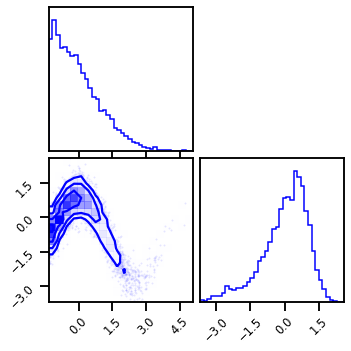

In [4]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [5]:
X = jnp.array(data, dtype=np.float64)

## DataLoader

In [6]:
from rbig_jax.data import GenericDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds_train = PlaneDataset(n_samples=n_train, noise=noise, seed=seed)
ds_valid = PlaneDataset(n_samples=n_valid, noise=noise, seed=seed)

# initialize dataloader
batch_size = 256
shuffle = True

train_dl = DataLoader(
    ds_train, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)
valid_dl = DataLoader(
    ds_valid, batch_size=batch_size, shuffle=False, collate_fn=None, num_workers=0
)

## Layer I - Univeriate KDE Transform

In [19]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.kde import InitUniKDETransform, estimate_bw

# histogram params
support_extension = 20
alpha = 1e-5
precision = 100
nbins = None  # init_bin_estimator("sqrt") #bins #cott"#int(np.sqrt(X.shape[0]))
jitted = True

# KDE specific Transform
bw = "scott"  # estimate_bw(X.shape[0], 1, "scott")

method = "kde"

init_hist_f = InitUniKDETransform(
    shape=X.shape, support_extension=support_extension, precision=precision, bw=bw
)


# univariate normalization Gaussianization parameters
eps = 1e-5
jitted = True

# initialize histogram transformation
init_icdf_f = InitInverseGaussCDF(eps=eps, jitted=jitted)

In [20]:
# initialize bijector
X_u, marg_u_bijector = init_hist_f.bijector_and_transform(X)

# forward with bijector
X_mg, icdf_bijector = init_icdf_f.bijector_and_transform(X_u)

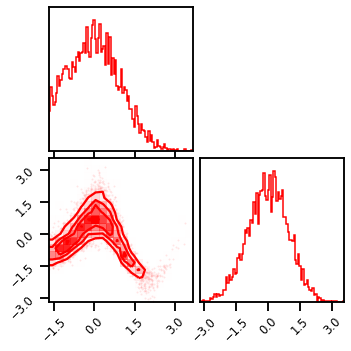

In [21]:
fig = corner.corner(X_mg, color="red", hist_bin_factor=5)

## Rotation

### Random Rotation

In [17]:
key, rr_rng = jax.random.split(KEY, 2)
n_features = X.shape[1]

V_random = jax.nn.initializers.orthogonal()(key=rr_rng, shape=(n_features, n_features))

X_r = jnp.dot(X_mg, V_random.T)

In [19]:
jnp.linalg.slogdet(V_random)[1]

DeviceArray(-1.3411045e-07, dtype=float32)

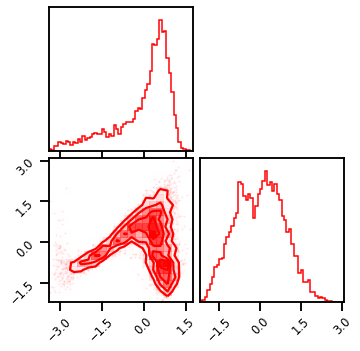

In [36]:
fig = corner.corner(X_r, color="red", hist_bin_factor=3)

### PCA Rotation

#### Sklearn

In [45]:
from sklearn.decomposition import PCA

pca_clf = PCA(random_state=123, whiten=True).fit(X_mg)

V_pca = pca_clf.components_.T

X_r = jnp.dot(X_mg, V_pca)

In [49]:
jnp.linalg.slogdet(V_pca)[1]

DeviceArray(1.11022302e-16, dtype=float64)

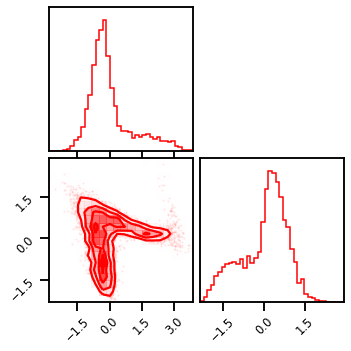

In [47]:
fig = corner.corner(X_r, color="red", hist_bin_factor=2)

#### From Scratch

In [50]:
# calculate svd

# remove mean
X_mg_ = X_mg - X_mg.mean(axis=0)

# compute svd
_, _, V_pca_ = jnp.linalg.svd(X_mg_, full_matrices=True, compute_uv=True)

X_r = jnp.dot(X_mg_, V_pca_.T)

In [51]:
jnp.linalg.slogdet(V_pca_)[1]

DeviceArray(1.11022302e-16, dtype=float64)

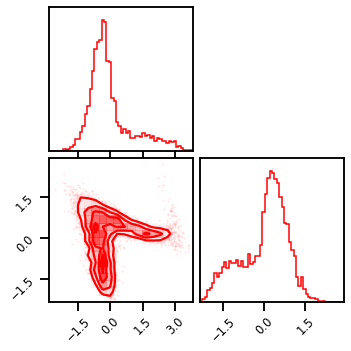

In [52]:
fig = corner.corner(X_r, color="red", hist_bin_factor=3)

### HouseHolder Reflection

**Advantages**

* Fully Parametric



In [115]:
from rbig_jax.transforms.parametric.householder import (
    householder_transform,
    householder_inverse_transform,
)


key, hh_rng = jax.random.split(key, 2)
n_features = X.shape[1]
n_reflections = 10

#### Random Init

In [119]:
# initialize random rotation matrix
V_r = jax.nn.initializers.orthogonal()(
    key=hh_rng, shape=(n_reflections, n_features), dtype=jnp.float64
)

# compute hh matrix
identity = jnp.identity(n_features, dtype=jnp.float64)

H_r = householder_inverse_transform(identity, V_r)
print(jnp.linalg.slogdet(H_r)[1])

# compute hh transform
X_r_hh = householder_transform(X_mg, V_r)
X_r_hh_ = X_mg @ H_r.T
chex.assert_tree_all_close(X_r_hh, X_r_hh_)

8.118505867571457e-16


In [126]:
V_r_ = householder_transform(identity, H_r)
print(V_r_.shape)

(2, 2)


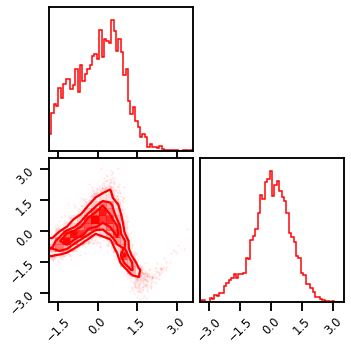

In [120]:
fig = corner.corner(X_r_hh, color="red", hist_bin_factor=3)

#### HouseHolder with PCA Init

TODO

In [125]:
# compute hh matrix
identity = jnp.identity(n_features, dtype=jnp.float64)

H_pca = householder_inverse_transform(identity, V_pca)
print(jnp.linalg.slogdet(H_pca)[1], H_pca.shape)

# compute hh transform
X_pca_hh = householder_transform(X_mg, V_pca)
X_pca_hh_ = X_mg @ H_pca.T
chex.assert_tree_all_close(X_pca_hh, X_pca_hh_)

-3.33066907387547e-16 (2, 2)


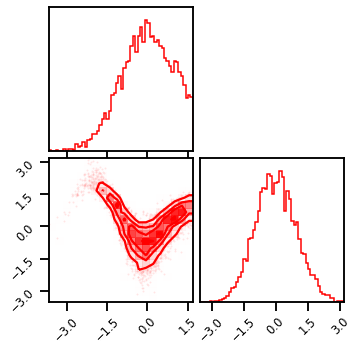

In [123]:
fig = corner.corner(X_pca_hh, color="red", hist_bin_factor=3)

In [66]:
# compute hh transform
X_hh_pca = householder_transform(X_mg, V_pca)

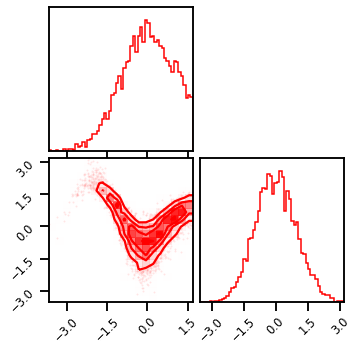

In [67]:
fig = corner.corner(X_hh_pca, color="red", hist_bin_factor=3)